In [2]:
# --- Import ---
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
from datasets import load_dataset, Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import numpy as np

In [3]:
# --- Core building blocks (LayerNorm, GELU, FFN, causal MHA) ---
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / math.pi, device=x.device, dtype=x.dtype)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        # causal mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, t, _ = x.shape
        q = self.W_query(x)
        k = self.W_key(x)
        v = self.W_value(x)
        q = q.view(b, t, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(b, t, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(b, t, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = q @ k.transpose(2, 3)
        mask_bool = self.mask.bool()[:t, :t]
        attn_scores.masked_fill_(mask_bool, float('-inf'))
        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ v).transpose(1, 2).contiguous().view(b, t, self.d_out)
        return self.out_proj(context_vec)

In [4]:
# --- Cross-attention block (no mask) ---
class Cross_MultiHead_Attention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context):
        b, t_q, _ = x.shape
        t_ctx = context.shape[1]
        q = self.W_query(x)
        k = self.W_key(context)
        v = self.W_value(context)
        q = q.view(b, t_q, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(b, t_ctx, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(b, t_ctx, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = q @ k.transpose(2, 3)
        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ v).transpose(1, 2).contiguous().view(b, t_q, self.d_out)
        return self.out_proj(context_vec)

class cross_attn_Block(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = Cross_MultiHead_Attention(
            d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"]
        )
        self.attn_norm = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x, context):
        shortcut = x
        x = self.attn_norm(x)
        x = self.att(x, context)
        x = self.drop_shortcut(x)
        return x + shortcut

In [5]:
# --- Transformer block ---
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        return x + shortcut

In [6]:
# --- Vision encoder + Perceiver Resampler + VisionAdapter ---
class TorchvisionViTEncoder(nn.Module):
    def __init__(self, arch="vit_b_16", pretrained=True, freeze=True):
        super().__init__()
        if arch == "vit_b_16":
            weights = ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
            base = vit_b_16(weights=weights)
        else:
            raise ValueError("Only vit_b_16 is implemented here.")
        self.model = base
        self.hidden_dim = base.hidden_dim
        if freeze:
            for p in self.parameters():
                p.requires_grad = False

    @torch.no_grad()
    def forward(self, images):
        features = self.model._process_input(images)  # (b, n, d)
        b, n, _ = features.shape
        cls_token = self.model.class_token.expand(b, -1, -1)
        x = torch.cat((cls_token, features), dim=1)
        x = self.model.encoder(x)
        patch_tokens = x[:, 1:, :]  # drop cls
        return patch_tokens

class PerceiverResampler(nn.Module):
    def __init__(self, dim, depth=2, num_latents=64, heads=8, dim_head=64, mlp_dim=256, dropout=0.0):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.depth = depth
        self.heads = heads
        self.scale = (dim_head) ** -0.5
        self.to_q = nn.ModuleList([nn.Linear(dim, heads * dim_head, bias=False) for _ in range(depth)])
        self.to_kv = nn.ModuleList([nn.Linear(dim, heads * dim_head * 2, bias=False) for _ in range(depth)])
        self.proj_out = nn.ModuleList([nn.Linear(heads * dim_head, dim, bias=False) for _ in range(depth)])
        self.norms_latent = nn.ModuleList([nn.LayerNorm(dim) for _ in range(depth)])
        self.norms_media  = nn.ModuleList([nn.LayerNorm(dim) for _ in range(depth)])
        self.mlp = nn.ModuleList([
            nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, mlp_dim), nn.GELU(), nn.Linear(mlp_dim, dim), nn.Dropout(dropout))
            for _ in range(depth)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, media_seq):
        b, t, d = media_seq.shape
        x = self.latents.unsqueeze(0).expand(b, -1, -1)
        for i in range(self.depth):
            q = self.to_q[i](self.norms_latent[i](x))
            kv = self.to_kv[i](self.norms_media[i](media_seq))
            k, v = kv.chunk(2, dim=-1)
            h = self.heads
            dh = q.shape[-1] // h
            q = q.view(b, -1, h, dh).transpose(1, 2)
            k = k.view(b, -1, h, dh).transpose(1, 2)
            v = v.view(b, -1, h, dh).transpose(1, 2)
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            out = attn @ v
            out = out.transpose(1, 2).contiguous().view(b, -1, h * dh)
            out = self.proj_out[i](out)
            x = x + self.dropout(out)
            x = x + self.mlp[i](x)
        return x

class VisionProjector(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.proj = nn.Identity() if in_dim == out_dim else nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.proj(x)

class VisionAdapter(nn.Module):
    def __init__(self, emb_dim, num_latents=64, perceiver_depth=2, perceiver_heads=8, perceiver_dim_head=64, dropout=0.0,
                encoder_type="torchvision_vit_b_16", pretrained=True, freeze=True):
        super().__init__()
        if encoder_type == "torchvision_vit_b_16":
            self.encoder = TorchvisionViTEncoder("vit_b_16", pretrained=pretrained, freeze=freeze)
            vision_dim = self.encoder.hidden_dim
            self.preprocess = ViT_B_16_Weights.IMAGENET1K_V1.transforms() if pretrained else None
        else:
            raise ValueError("Unsupported encoder_type")
        self.project = VisionProjector(vision_dim, emb_dim)
        self.resampler = PerceiverResampler(dim=emb_dim, depth=perceiver_depth, num_latents=num_latents,
                                            heads=perceiver_heads, dim_head=perceiver_dim_head, dropout=dropout)
    def forward(self, images):
        feats = self.encoder(images)
        feats = self.project(feats)
        visual_tokens = self.resampler(feats)
        return visual_tokens

In [7]:
# --- GPTModal with optional vision injection at specified layers ---
class GPTModal(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.ModuleList([])
        for i in range(cfg["n_layers"]):
            if i in cfg["cross_attention_pos"]:
                self.trf_blocks.append(cross_attn_Block(cfg))
            self.trf_blocks.append(TransformerBlock(cfg))
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        self.vision_enabled = cfg.get("vision_enabled", True)
        if self.vision_enabled:
            self.vision = VisionAdapter(
                emb_dim=cfg["emb_dim"],
                num_latents=cfg.get("perceiver_num_latents", 64),
                perceiver_depth=cfg.get("perceiver_depth", 2),
                perceiver_heads=cfg.get("perceiver_heads", 8),
                perceiver_dim_head=cfg.get("perceiver_dim_head", 64),
                dropout=cfg.get("drop_rate", 0.0),
                encoder_type=cfg.get("vision_encoder_type", "torchvision_vit_b_16"),
                pretrained=cfg.get("vision_pretrained", True),
                freeze=cfg.get("vision_freeze", True)
            )
        else:
            self.vision = None

    def forward(self, in_idx, images=None):
      device = in_idx.device
      b, T = in_idx.shape
      pos = torch.arange(T, device=device, dtype=torch.long)
      tok = self.tok_emb(in_idx)                    # (B, T, D)
      pos_emb = self.pos_emb(pos).unsqueeze(0)      # (1, T, D) broadcast over batch
      x = tok + pos_emb
      x = self.drop_emb(x)

      visual_context = None
      if self.vision is not None and images is not None:
          images = images.to(device)
          visual_context = self.vision(images)      # (B, L, D)

      for layer in self.trf_blocks:
          if isinstance(layer, TransformerBlock):
              x = layer(x)
          elif isinstance(layer, cross_attn_Block) and visual_context is not None:
              x = layer(x, visual_context)

      x = self.final_norm(x)
      logits = self.out_head(x)
      return logits

In [8]:
# --- Freeze utilities and parameter counting ---
def freeze_gpt_text_backbone(gpt, freeze_embeddings=True, freeze_transformer_blocks=True, freeze_final_ln=True, freeze_lm_head=True):
    if freeze_embeddings:
        for p in gpt.tok_emb.parameters(): p.requires_grad = False
        for p in gpt.pos_emb.parameters(): p.requires_grad = False
    if freeze_transformer_blocks:
        for blk in gpt.trf_blocks:
            if isinstance(blk, TransformerBlock):
                for p in blk.parameters():
                    p.requires_grad = False
    if freeze_final_ln:
        for p in gpt.final_norm.parameters(): p.requires_grad = False
    if freeze_lm_head:
        for p in gpt.out_head.parameters(): p.requires_grad = False

def count_trainable_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,}")
    print(f"Total params:     {total:,}")
    return trainable, total

In [9]:
#  --- Config and model instantiation ---
cfg = {
    "vocab_size": 50257,          # GPT-2
    "emb_dim": 768,               # GPT-2 small
    "context_length": 256,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True,
    "cross_attention_pos": [2, 5, 8, 11],  # insert cross-attn before these TransformerBlocks

    "vision_enabled": True,
    "vision_encoder_type": "torchvision_vit_b_16",
    "vision_pretrained": True,
    "vision_freeze": True,

    "perceiver_num_latents": 64,
    "perceiver_depth": 2,
    "perceiver_heads": 8,
    "perceiver_dim_head": 64,

    "weight_decay": 0.01,
    "learning_rate": 1e-4,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt = GPTModal(cfg).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 180MB/s]


In [13]:
# --- Model Loading ---
# 1. Fix vocabulary size mismatch
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "<|pad|>"})

# Update config to match actual vocab size
cfg["vocab_size"] = len(tokenizer)

# 2. Recreate model with correct vocab size and context length
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt = GPTModal(cfg).to(device)

# 3. Load GPT-2 weights with proper device handling and context length handling
hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd = hf.state_dict()
params = {k: v.cpu().numpy() for k, v in sd.items()}

# Copy original token embeddings and add random initialization for new pad token
original_tok_embeddings = torch.tensor(params['transformer.wte.weight'], device=device)
new_tok_embeddings = torch.randn(cfg["vocab_size"], cfg["emb_dim"], device=device) * 0.02
new_tok_embeddings[:original_tok_embeddings.size(0)] = original_tok_embeddings
gpt.tok_emb.weight = nn.Parameter(new_tok_embeddings)

# Handle position embeddings based on model's context length
original_pos_embeddings = torch.tensor(params['transformer.wpe.weight'], device=device)
if cfg["context_length"] > original_pos_embeddings.size(0):
    # Initialize new position embeddings randomly if current context length is larger
    new_pos_embeddings = torch.randn(cfg["context_length"], cfg["emb_dim"], device=device) * 0.02
    new_pos_embeddings[:original_pos_embeddings.size(0)] = original_pos_embeddings
    gpt.pos_emb.weight = nn.Parameter(new_pos_embeddings)
else:
    # Use only the required position embeddings from the checkpoint
    gpt.pos_emb.weight = nn.Parameter(original_pos_embeddings[:cfg["context_length"], :].clone())


# Load transformer blocks (unchanged from your original code but ensure device placement)
trf_only = [blk for blk in gpt.trf_blocks if isinstance(blk, TransformerBlock)]
for i, blk in enumerate(trf_only):
    w_qkv = params[f'transformer.h.{i}.attn.c_attn.weight']
    b_qkv = params[f'transformer.h.{i}.attn.c_attn.bias']
    q_w, k_w, v_w = np.split(w_qkv, 3, axis=-1)
    q_b, k_b, v_b = np.split(b_qkv, 3, axis=-1)

    blk.att.W_query.weight = nn.Parameter(torch.tensor(q_w.T, device=device))
    blk.att.W_key.weight   = nn.Parameter(torch.tensor(k_w.T, device=device))
    blk.att.W_value.weight = nn.Parameter(torch.tensor(v_w.T, device=device))
    blk.att.W_query.bias   = nn.Parameter(torch.tensor(q_b, device=device))
    blk.att.W_key.bias     = nn.Parameter(torch.tensor(k_b, device=device))
    blk.att.W_value.bias   = nn.Parameter(torch.tensor(v_b, device=device))

    blk.att.out_proj.weight = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.attn.c_proj.weight'].T, device=device))
    blk.att.out_proj.bias   = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.attn.c_proj.bias'], device=device))

    blk.ff.layers[0].weight = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_fc.weight'].T, device=device))
    blk.ff.layers[0].bias   = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_fc.bias'], device=device))
    blk.ff.layers[2].weight = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_proj.weight'].T, device=device))
    blk.ff.layers[2].bias   = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_proj.bias'], device=device))

    blk.norm1.scale = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_1.weight'], device=device))
    blk.norm1.shift = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_1.bias'], device=device))
    blk.norm2.scale = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_2.weight'], device=device))
    blk.norm2.shift = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_2.bias'], device=device))

# Load final layer norm - move to device
gpt.final_norm.scale = nn.Parameter(torch.tensor(params['transformer.ln_f.weight'], device=device))
gpt.final_norm.shift = nn.Parameter(torch.tensor(params['transformer.ln_f.bias'], device=device))

# Tie embeddings (use the new expanded embedding matrix)
gpt.out_head.weight = gpt.tok_emb.weight

print(f"Model successfully loaded on {device}")
print(f"Vocab size: {cfg['vocab_size']}")
print(f"Embedding matrix device: {gpt.tok_emb.weight.device}")
print(f"Position embedding device: {gpt.pos_emb.weight.device}")

Model successfully loaded on cuda
Vocab size: 50258
Embedding matrix device: cuda:0
Position embedding device: cuda:0


In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2TokenizerFast
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_trained_model(checkpoint_path, device=None):
    import os
    import json

    checkpoint_path = "/content/drive/MyDrive/vision_gpt_model"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load config from checkpoint (this contains the correct context_length)
    config_path = os.path.join(checkpoint_path, 'config.json')
    with open(config_path, 'r') as f:
        cfg = json.load(f)

    print(f"Checkpoint config context_length: {cfg.get('context_length', 'Not found')}")

    # Load tokenizer
    tokenizer_path = os.path.join(checkpoint_path, 'tokenizer')
    tokenizer = GPT2TokenizerFast.from_pretrained(tokenizer_path)

    # Create model with checkpoint's config
    model = GPTModal(cfg).to(device)

    # Load weights
    model_path = os.path.join(checkpoint_path, 'model_checkpoint.pth')
    checkpoint_data = torch.load(model_path, map_location=device)

    # Handle position embedding size mismatch if needed
    state_dict = checkpoint_data['model_state_dict']
    current_pos_emb_size = model.pos_emb.weight.shape[0]
    checkpoint_pos_emb_size = state_dict['pos_emb.weight'].shape[0]

    if current_pos_emb_size != checkpoint_pos_emb_size:
        print(f"⚠ Position embedding size mismatch:")
        print(f"  Current: {current_pos_emb_size}, Checkpoint: {checkpoint_pos_emb_size}")
        print(f"  Truncating to match current model")
        # Use only the first current_pos_emb_size positions from checkpoint
        state_dict['pos_emb.weight'] = state_dict['pos_emb.weight'][:current_pos_emb_size, :]

    model.load_state_dict(state_dict)
    model.eval()

    print(f"✓ Model loaded successfully!")
    print(f"  Context length: {cfg['context_length']}")

    return model, tokenizer, cfg # Added return statement

def prepare_image(image_path_or_pil, size=(224, 224)):
    # Load image if path provided
    if isinstance(image_path_or_pil, str):
        image = Image.open(image_path_or_pil).convert('RGB')
    else:
        image = image_path_or_pil.convert('RGB')

    # Define transforms (same as training)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return img_tensor, image

def top_k_top_p_filtering(logits, top_k=0, top_p=1.0):
    if top_k > 0:
        values, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        min_values = values[..., -1, None]
        logits = torch.where(
            logits < min_values,
            torch.full_like(logits, float('-inf')),
            logits
        )

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)
        sorted_mask = cumulative_probs > top_p
        sorted_mask[..., 1:] = sorted_mask[..., :-1].clone()
        sorted_mask[..., 0] = False
        logits = logits.scatter(
            1, sorted_indices,
            sorted_logits.masked_fill(sorted_mask, float('-inf'))
        )

    return logits


@torch.no_grad()
def generate_caption(model,tokenizer,image_tensor,max_new_tokens=50,temperature=0.7,top_p=0.9,top_k=50,device=None):
    model.eval()

    if device is None:
        device = next(model.parameters()).device

    image_tensor = image_tensor.to(device)

    # Start with BOS token
    bos_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
    eos_id = tokenizer.eos_token_id

    input_ids = torch.tensor([[bos_id]], dtype=torch.long, device=device)

    generated_tokens = []

    for step in range(max_new_tokens):
        # Forward pass
        logits = model(input_ids, images=image_tensor)
        next_token_logits = logits[:, -1, :] / max(temperature, 1e-8)

        # Apply filtering
        filtered_logits = top_k_top_p_filtering(
            next_token_logits,
            top_k=top_k,
            top_p=top_p
        )

        # Sample next token
        probs = F.softmax(filtered_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to sequence
        input_ids = torch.cat([input_ids, next_token], dim=1)
        generated_tokens.append(next_token.item())

        # Stop if EOS generated
        if eos_id is not None and next_token.item() == eos_id:
            break

    # Decode to text
    caption = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return caption.strip()

def visualize_prediction(image, caption, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Generated Caption:\n{caption}",
            fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Saved visualization to: {save_path}")

    plt.show()


def test_multiple_images(model, tokenizer, image_paths, device=None, **gen_kwargs):
    if device is None:
        device = next(model.parameters()).device

    results = []

    for idx, img_path in enumerate(image_paths, 1):
        try:
            # Prepare image
            img_tensor, orig_img = prepare_image(img_path)

            # Generate caption
            caption = generate_caption(
                model, tokenizer, img_tensor, device=device, **gen_kwargs
            )

            print(f"  Caption: {caption}\n")

            # Visualize
            visualize_prediction(orig_img, caption)

            results.append({
                'image_path': img_path,
                'caption': caption,
                'success': True
            })

        except Exception as e:
            print(f"  ✗ Error: {str(e)}\n")
            results.append({
                'image_path': img_path,
                'caption': None,
                'success': False,
                'error': str(e)
            })

    return results

In [25]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# Load model
checkpoint_path = "/content/drive/MyDrive/vision_gpt_model"  # Update with your path
model, tokenizer, cfg = load_trained_model(checkpoint_path, device)

Using device: cuda

Checkpoint config context_length: 256
⚠ Position embedding size mismatch:
  Current: 256, Checkpoint: 1024
  Truncating to match current model
✓ Model loaded successfully!
  Context length: 256


  Caption: A small kitchen with cabinets and shelves in both directions and a stove.



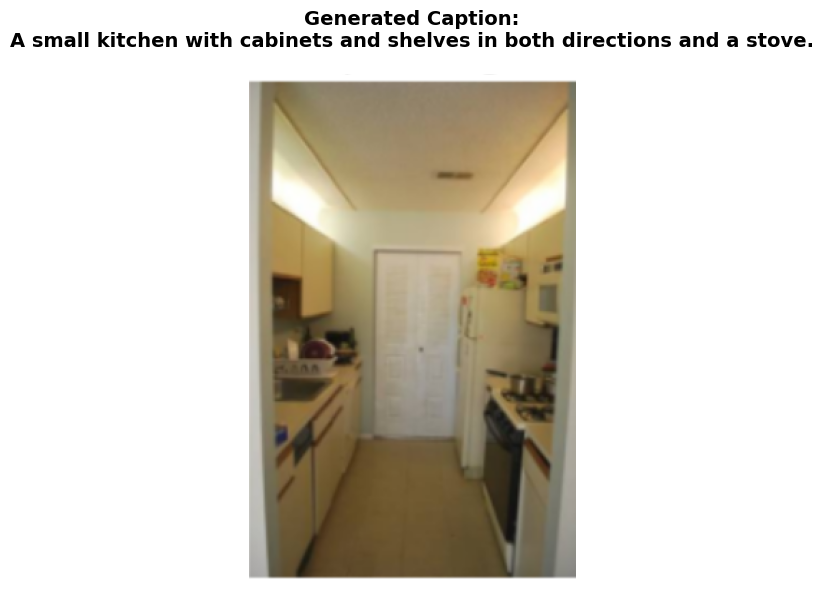

  Caption: A bathroom with a sink and a shelf for the sink and toilet.



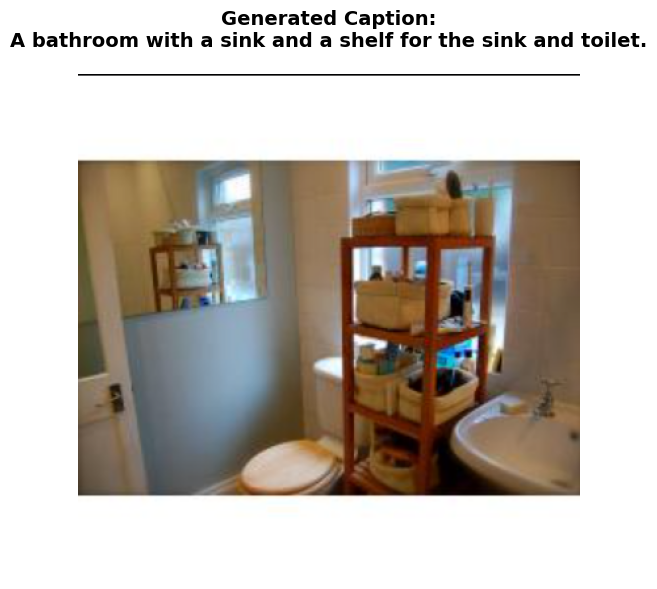

  Caption: A kid riding a skateboard in a park.



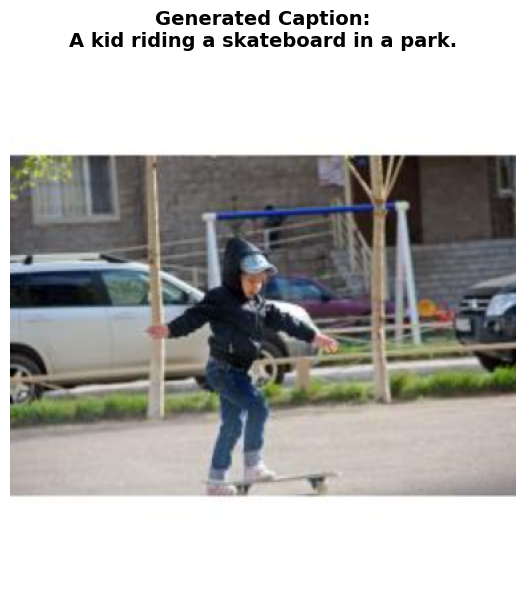

In [35]:
test_images = [
    "/content/Screenshot 2025-10-11 203512.png",
    "/content/Screenshot 2025-10-11 204847.png",
    "/content/Screenshot 2025-10-11 204903.png",
]

results = test_multiple_images(
    model, tokenizer, test_images, device,
    max_new_tokens=50,
    temperature=1,
    top_p=0.9
)